In [26]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

from plotnine import *

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.stattools import adfuller, kpss

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

from statsmodels.tsa.api import AutoReg

from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

from scipy.stats import boxcox

from statsmodels.stats.diagnostic import acorr_ljungbox



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox



In [27]:
# Dataset: co2
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

# Dataset: AirPassengers
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

# Dataset
url1='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/life_expectancy_birth.csv'
url2='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/milk_production.csv'

life = pd.read_csv(url1, 
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)

milk = pd.read_csv(url2, 
                   index_col='month', 
                   parse_dates=True)

C:\Users\Pc\AppData\Local\Temp/ipykernel_10128/3748741975.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


# Modelo Sazonal ARIMA

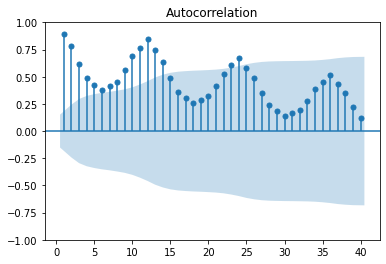

In [28]:
plot_acf(milk, lags=40, zero=False);plt.show()

# Efeito sazonal Aditivo e possui tendência: periodicidade é 12. Os dados são mensais.

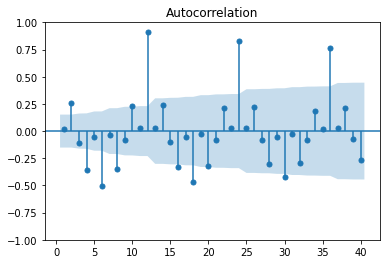

In [29]:
# Destrinche (diferenciação de primeira ordem) os dados primeiro e, em seguida, plote o gráfico ACF:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); 
plt.show()


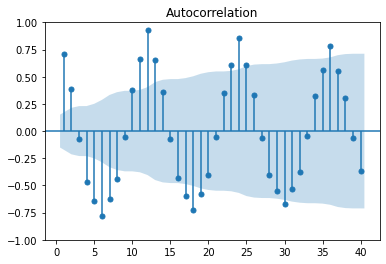

In [30]:
# Você também pode extrair o componente sazonal e usá-lo para o gráfico ACF
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
milk_s = decomposed.seasonal
plot_acf(milk_s, zero=False, lags=40);plt.show() # Plot na componente sazonal

# O gráfico ACF mostrará a autocorrelação usando o componente sazonal 


- Comece com a diferenciação sazonal usando diff(12) (desazonalizar) e teste se isso é suficiente para tornar a série temporal estacionária. Caso contrário, você precisará segui-lo com uma diferenciação de primeira ordem, diff():

In [31]:
# Testes estatísticos
    #  ADF: a hipótese nula afirma que existe uma raiz unitária na série temporal e, portanto, é não estacionária. 
    #  KPSS: tem a hipótese nula oposta, que assume que a série temporal é estacionária. 
    
# Teste de estacionariedade 
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05: 
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])



'Non-Stationary	 p-value:0.6274267086030331 	 lags:13
'Non-Stationary	 p-value:0.16079880527711227 	 lags:12
'Stationary	 p-value:1.86542343187882e-05 	 lags:11


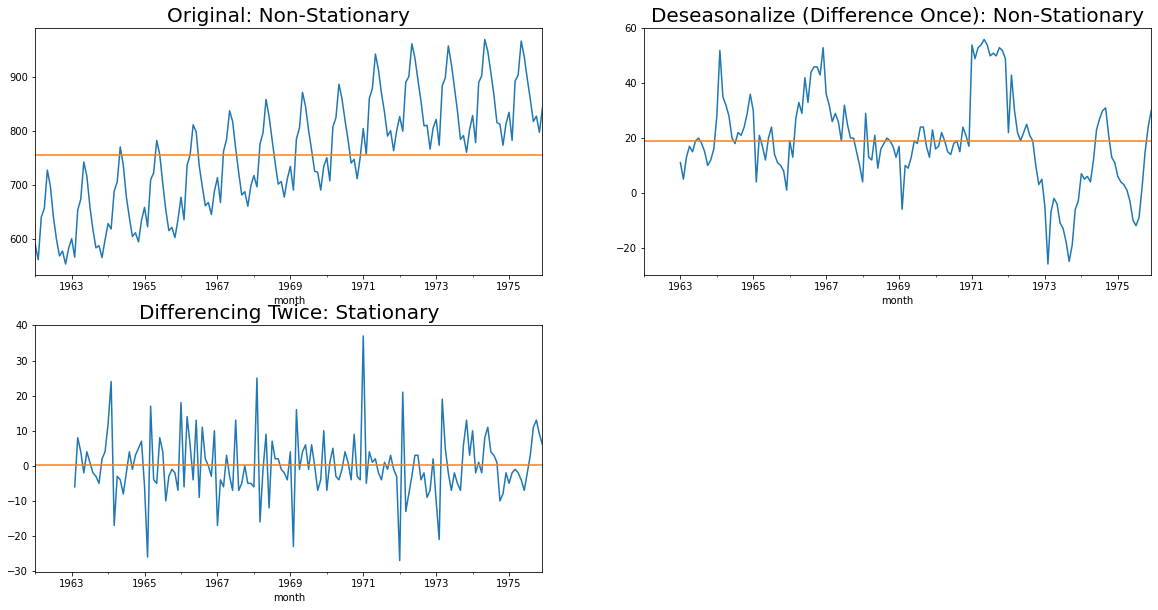

In [32]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

sets = [milk, milk_dif_12, milk_dif_12_1]

desc = ['Original', 'Deseasonalize (Difference Once)','Differencing Twice']

fig, ax = plt.subplots(2,2, figsize=(20,10))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', 
legend=False)
    pd.Series(d_set.mean().values.tolist()*l, 
index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.show() 


- Agora, você precisará estimar as ordens AR e MA para os componentes não sazonais (p, q) e sazonais (P, Q). 

1. Para fazer isso, você deve usar os gráficos ACF e PACF nos dados estacionários, que podem ser encontrados no milk_dif_12_1 DataFrame:

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


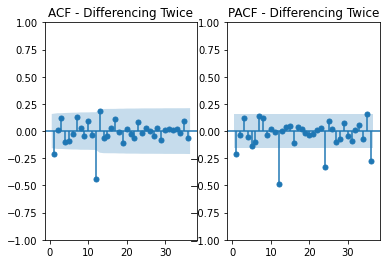

In [33]:
fig, ax = plt.subplots(1,2)

plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], 
title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], 
title=f'PACF - {d_desc}')
plt.show()

# ACF: q=1 e Q=1. 
#  PACF também confirma isso; um decaimento exponencial nas defasagens 12, 24 e 36 indica um modelo MA.
# ARIMA sazonal seria ARIMA(0, 1,1)(0, 1, 1, 12)

In [34]:
# SPLIT: Função para criar train e test data set
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test



# Definindo dados de treino e teste

test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)

life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [35]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


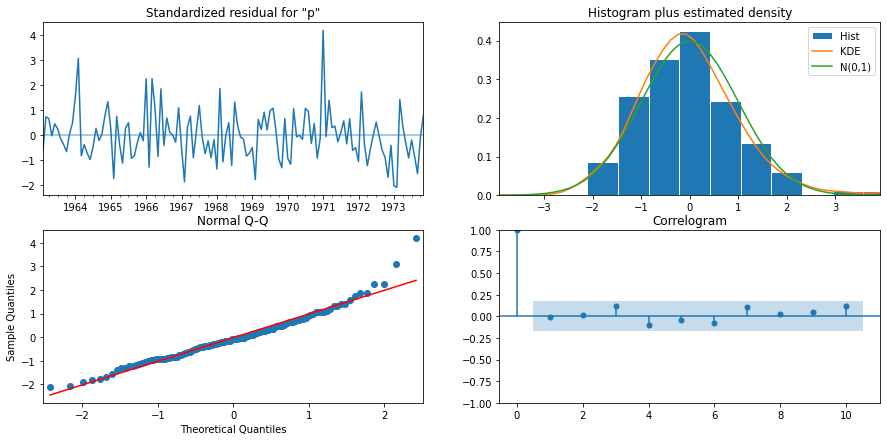

In [36]:
# Agora, utilize o método plot_diagnostics, que fica disponível após o ajuste do modelo:
model.plot_diagnostics(figsize=(15,7)); plt.show()

# O gráfico ACF do resíduo (correlograma) não mostra autocorrelação (ignorando o pico no atraso 0, pois é sempre 1).
# o QQPlot mostram que os resíduos não se ajustam a uma distribuição perfeitamente normal.
# Essas não são suposições críticas em comparação com resíduos aleatórios (sem autocorrelação)
# No geral, os resultados parecem muito promissores.

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Tue, 29 Nov 2022   AIC                            903.335
Time:                                    23:35:13   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

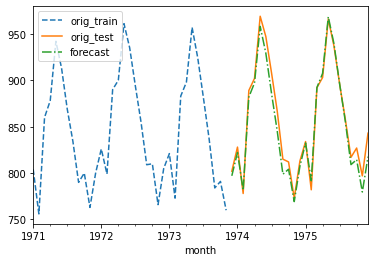

In [38]:
# A etapa final é criar uma previsão (previsão) e compará-la com seu conjunto de dados de teste (invisível ou fora dos dados de amostra).

# Função: Crie a função plot_forecast, que usa um objeto de modelo que você treinou, uma posição inicial e os conjuntos de dados de treinamento 
# e teste para criar um gráfico que compara a previsão (valores previstos) com os reais.

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()


# Use a função plot_forecast para plotar a previsão do modelo SARIMA e compará-la com o conjunto de teste:
plot_forecast(model, '1971', milk_train, milk_test)


In [39]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [40]:
# Auto ML considerando periodicidade 12

P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])


score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so 

Running model #15 using SARIMA(0,0,1)(1,1,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal mov

Running model #30 using SARIMA(0,1,0)(1,1,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #45 using SARIMA(0,1,2)(1,0,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #60 using SARIMA(0,2,1)(1,0,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #75 using SARIMA(1,0,0)(0,1,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #90 using SARIMA(1,0,2)(0,1,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #105 using SARIMA(1,1,1)(0,0,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #120 using SARIMA(1,2,0)(0,0,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #135 using SARIMA(1,2,1)(1,1,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #150 using SARIMA(2,0,0)(1,1,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #165 using SARIMA(2,0,2)(1,0,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M

Running model #180 using SARIMA(2,1,1)(1,0,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M

Running model #195 using SARIMA(2,2,0)(0,1,1,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

Running model #210 using SARIMA(2,2,2)(0,1,0,12)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

In [42]:
# Função: Melhor modelo para determinado criterio
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [43]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217653037098


In [44]:
# Inspecionando modelo
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.4217653037098,
 'AICc': 796.2068120326817,
 'BIC': 811.8389559940767,
 'RMSPE': 0.17819001998777678,
 'RMSE': 15.135871421478031,
 'MAPE': 0.0144542735985929,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f0f1f50ca0>}

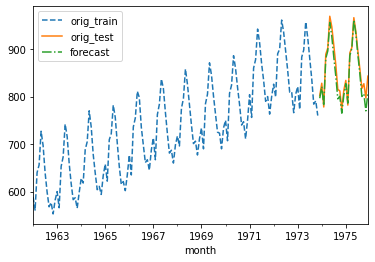

In [45]:
# Por fim, você pode prever e plotar o modelo usando a função plot_forecast
plot_forecast(best_model, '1962', milk_train, milk_test)


In [46]:
# Tabulando resultados
pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135871,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328241,27.797287,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,191,"(2, 1, 2)","(1, 1, 1)",796.833532,797.880261,816.048057,0.112276,9.649864,0.009076,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998609,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
...,...,...,...,...,...,...,...,...,...,...
211,9,"(0, 0, 1)","(0, 0, 1)",1793.898529,1794.090529,1802.477966,7.839438,676.60274,0.736909,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
212,16,"(0, 0, 2)","(0, 0, 0)",1918.255872,1918.432342,1927.080799,9.732186,839.743278,0.963643,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
213,1,"(0, 0, 0)","(0, 0, 1)",1951.580397,1951.674885,1957.315466,8.075222,694.500229,0.771746,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
214,8,"(0, 0, 1)","(0, 0, 0)",2089.817778,2089.904735,2095.715298,9.845278,848.617277,0.979282,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
